<a href="https://colab.research.google.com/github/Bryan-Az/TF-PyTorch-Jax-NN/blob/main/Tensorflow-NN/EinsumVMatrix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Tensorflow High Level API Network Experiment Using Einsum in the Forward Pass


# Imports

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras import Sequential

# Creating Synthetically Generated Data using Environmental Data Distributions

## Loading and Processing Numerical Features
This will help when processing with the regression model. This data was previously processed in my 'Keras-HF-FastAi' repository when preparing it to be used with the HuggingFace pre-trained "Tabular Question Answering" M.L model. During an earlier processing step when preparing the data for training with FastAi API model-training data loader methods and Sci-kit Learn's "AdaBoostRegressor" model, it was noticed that the data performed better in regression when the original features like working_capacity, fish_production, crop_production_capacity, etc were split into its tuple components, versus when the tuple components were merged into a single feature. This may be due to each component (feature_1, feature_2, etc.) representing a distinct latent variable. For further information for how the data was processed, refert to my 'Keras-HF-FastAi' repository.

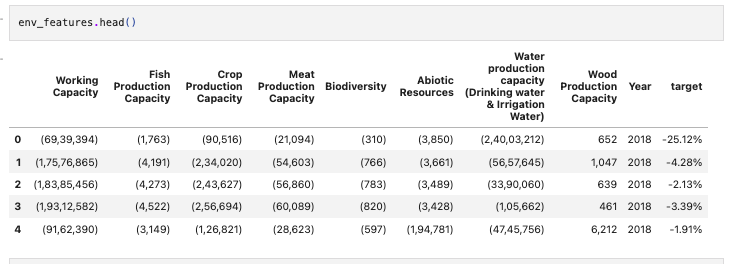

In [106]:
environmental_data = pd.read_csv('../data/corp_safeguard_split.csv')

In [107]:
environmental_data.head()

,working_capacity_0,working_capacity_1,working_capacity_2,working_capacity_3,fish_production_capacity_0,fish_production_capacity_1,crop_production_capacity_0,crop_production_capacity_1,crop_production_capacity_2,meat_production_capacity_0,...,biodiversity_0,biodiversity_1,abiotic_resources_0,abiotic_resources_1,water_production_capacity_(drinking_water_&_irrigation_water)_0,water_production_capacity_(drinking_water_&_irrigation_water)_1,water_production_capacity_(drinking_water_&_irrigation_water)_2,Year,Company Name,target
0,69,39,394.0,445.799955,1,763.0,90,516.0,437.036571,21,...,310,418.64977,3.0,850.0,2,40.0,3.0,2018,APPLUS SERVICES SA,-0.2512
1,1,75,76.0,865.000000,4,191.0,2,34.0,20.000000,54,...,766,418.64977,3.0,661.0,56,57.0,645.0,2018,TELEPERFORMANCE SE,-0.0428
2,1,83,85.0,456.000000,4,273.0,2,43.0,627.000000,56,...,783,418.64977,3.0,489.0,33,90.0,60.0,2018,SGS SA,-0.0213
3,1,93,12.0,582.000000,4,522.0,2,56.0,694.000000,60,...,820,418.64977,3.0,428.0,1,5.0,662.0,2018,INTERTEK GROUP PLC,-0.0339
4,91,62,390.0,445.799955,3,149.0,1,26.0,821.000000,28,...,597,418.64977,1.0,94.0,47,45.0,756.0,2018,THOMSON REUTERS CORP,-0.0191


## Feature Selection for Synthetic Modelling of the Feature Distributions
In the Numpy notebook, exploratory data analysis was used to find 2-3 features within the data that would be good choices to non linear regression. In this section, a similar method will be used to apply non-linear regression using PyTorch low-level functionality that also allows for the creation of a regression model in an object-oriented fashion. For the generation of the synthetic distributions, we need to identify the distribution type and the distribution parameters within the base data, as each variable feature has different distribution characteristics.

### Identifying the distributions & the distribution parameters

In [108]:
numerical_features = environmental_data.drop(['Company Name'], axis=1)

In this notebook, I will be using the same 3 features (+ the target) identified using the boxplot in the numpy notebook to generate the synthetic distributions. This time, I will be plotting the results in a 4D-plot. I am filtering the data to remove outliers and selecting the 5 most recent years. 

In [109]:
most_recent_year = numerical_features['Year'].max()

# Select rows that are within the 5 most recent years
recent_features = numerical_features[numerical_features['Year'] > most_recent_year - 5]

In [110]:
recent_features = recent_features.drop('Year', axis=1) # dropping year as it is not a environmental signal

In [111]:
means = recent_features.mean()
stds = recent_features.std()

# Calculate ymin and ymax for each column
ymins = means - 3 * stds
ymaxs = means + 3 * stds

# Filtering the DataFrame to only include values within ymin and ymax for each column
filtered_numerical_features = recent_features[(recent_features >= ymins) & (recent_features <= ymaxs)].dropna()

In [112]:
print(numerical_features.shape)
print(filtered_numerical_features.shape)

(13177, 20)
(6557, 19)


In [113]:
filtered_numerical_features.describe()

,working_capacity_0,working_capacity_1,working_capacity_2,working_capacity_3,fish_production_capacity_0,fish_production_capacity_1,crop_production_capacity_0,crop_production_capacity_1,crop_production_capacity_2,meat_production_capacity_0,meat_production_capacity_1,biodiversity_0,biodiversity_1,abiotic_resources_0,abiotic_resources_1,water_production_capacity_(drinking_water_&_irrigation_water)_0,water_production_capacity_(drinking_water_&_irrigation_water)_1,water_production_capacity_(drinking_water_&_irrigation_water)_2,target
count,6557.000000,6557.000000,6557.000000,6557.000000,6557.000000,6557.000000,6557.000000,6557.000000,6557.000000,6557.000000,6557.000000,6557.000000,6557.000000,6557.000000,6557.000000,6557.000000,6557.000000,6557.000000,6557.000000
mean,20.038585,47.946317,166.746314,443.951521,55.387067,404.281205,19.543389,140.833350,436.210039,21.488181,257.649295,138.462102,420.556388,50.673241,353.629845,20.977429,99.035405,328.361269,-1.143813
std,25.243661,28.918262,249.319003,266.964169,129.647023,298.084564,24.676803,221.374304,271.516195,28.661700,300.369591,226.135342,239.393191,117.611291,295.907676,24.889863,156.221839,293.447537,5.008250
min,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,-97.108400
25%,3.000000,23.000000,32.000000,240.000000,3.000000,103.000000,3.000000,27.000000,214.000000,2.000000,38.000000,2.000000,276.000000,3.000000,73.000000,3.000000,26.000000,65.000000,-0.511900
50%,8.000000,47.000000,65.000000,445.799955,9.000000,400.997112,8.000000,57.000000,437.036571,9.000000,83.000000,14.000000,418.649770,10.000000,357.948948,10.000000,53.000000,322.000000,-0.105000
75%,27.000000,73.000000,97.000000,614.000000,31.000000,649.000000,26.000000,92.000000,617.000000,32.000000,457.000000,197.000000,505.000000,35.000000,576.000000,32.000000,84.000000,534.000000,-0.028000
max,97.000000,185.000000,999.000000,999.000000,706.000000,999.000000,141.000000,957.000000,999.000000,382.000000,999.000000,887.000000,999.000000,694.000000,999.000000,99.000000,808.000000,999.000000,44.022300


In [114]:
X = filtered_numerical_features.loc[:, ['biodiversity_0', 'biodiversity_1','working_capacity_3']]

In [115]:
y = filtered_numerical_features.loc[:, 'target']

In [116]:
def plot_4d(x, y, z, c, title='4D Plot'):
    """ This function plots the 3 X variables 
    as points, and uses color to visualize the target variable.
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Assuming x, y, z, and c are numpy arrays or lists of the same length
    # x, y, and z are the coordinates, and c is the color dimension
    ax.scatter(x, y, z, c=c, cmap=plt.hot())
    
    # Add a colorbar to represent the fourth dimension
    fig.colorbar(ax.scatter(x, y, z, c=c, cmap=plt.hot()),ax=ax, label='Environmental Cost Intensity (%)')
    
    plt.title(title)
    plt.show()

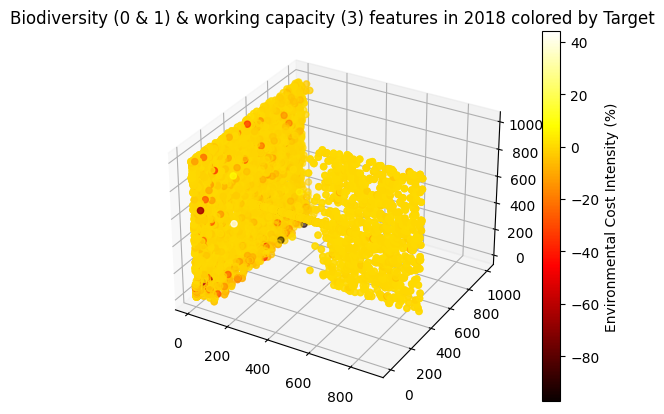

In [117]:
plot_4d(X['biodiversity_0'], X['biodiversity_1'], X['working_capacity_3'], y, title='Biodiversity (0 & 1) & working capacity (3) features in 2018 colored by Target')

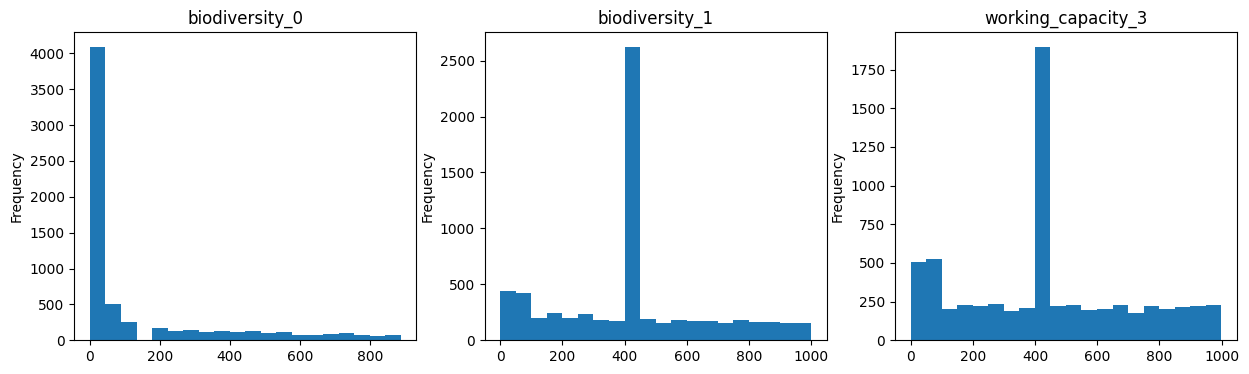

In [118]:
# Create a figure and a grid of subplots
fig, axs = plt.subplots(1, 3, figsize=(3 * 5, 4))

# Flatten the array of axes (subplots) for easy iteration
axs_flat = axs.flatten()

for i, column in enumerate(X.columns):
    # Plot the column data in its own subplot
    filtered_numerical_features[column].plot(kind='hist', bins=20, ax=axs_flat[i])
    axs_flat[i].set_title(column) 

<Axes: ylabel='Frequency'>

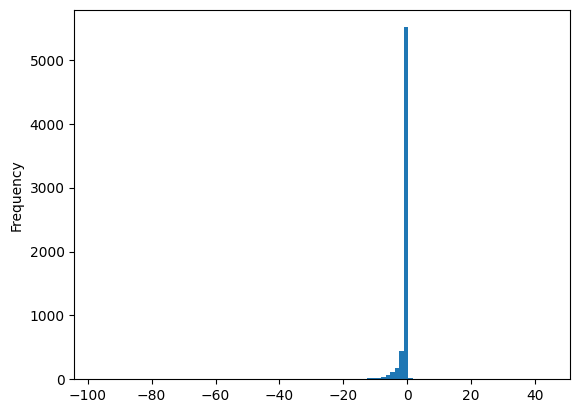

In [119]:
y.plot(kind='hist', bins=100)

Thoughts on the underlying distributions based on the histograms: 
1. The biodiversity_0 feature may be an inverse exponential distribution.
2. The biodiversity_1 feature may be an irregular gaussian as there is a spike near 400.
3. The working_capacity_3 feature may also be an irregular gaussian as there is a spike near 400.
4. The target (environmental cost intensity) feature may be an exponential distribution shifted to the left.

Further hypothesis testing may be done to uncover the underlying distributions generating the data, however, for the purposes of this assignment I will continue by generating the data based on these assumptions.

### Generating the Synthetic Data

In [120]:
def generate_samples(distribution, mean, std_dev, size=len(numerical_features)):
    """
    Generate samples from specified distribution using mean and standard deviation.
    
    :param distribution: str, Type of distribution ('gaussian', 'exponential', 'inverse_exponential')
    :param mean: float, Mean of the distribution
    :param std_dev: float, Standard deviation of the distribution (not used for exponential)
    :param size: int, Number of samples to generate
    :return: np.array, Array of generated samples
    """
    if distribution == 'gaussian':
        samples = np.random.normal(loc=mean, scale=std_dev, size=size)
    elif distribution == 'exponential':
        # For exponential distribution, mean = 1/lambda
        rate = abs(mean)
        shift = 2 # shift is a variable chosen by the analyst to better fine-tune the synthetic distribution
        samples = -1 * (1/np.random.exponential(scale=1/rate, size=size))
        samples = samples + shift
    elif distribution == 'inverse_exponential':
        # Generate exponential and take reciprocal
        rate = mean
        samples = 1 / np.random.exponential(scale=1/rate, size=size)
    else:
        raise ValueError("Unsupported distribution type. Choose 'gaussian', 'exponential', or 'inverse_exponential'.")
    
    return samples

In [121]:
synthetic_env_data = pd.DataFrame({
    'synthetic_biodiversity_0': generate_samples('inverse_exponential', means['biodiversity_0'], stds['biodiversity_0']),
    'synthetic_biodiversity_1': generate_samples('gaussian', means['biodiversity_1'], stds['biodiversity_1']),
    'synthetic_working_capacity_3': generate_samples('gaussian', means['working_capacity_3'], stds['working_capacity_3']),
    'synthetic_target': generate_samples('exponential', means['target'], stds['target'])
})

In [122]:
means_X = X.mean()
stds_X = X.std()

# Calculate ymin and ymax for each column
mins_X = means_X - 3 * stds_X
maxs_X = means_X + 3 * stds_X

means_Y = y.mean()
stds_Y = y.std()

# Calculate ymin and ymax for each column
mins_Y = means_Y - 3 * stds_Y
maxs_Y = means_Y + 3 * stds_Y

In [123]:
all_mins = pd.concat([mins_X,pd.Series({'target':mins_Y})], axis=0)

In [124]:
all_maxs = pd.concat([maxs_X,pd.Series({'target':maxs_Y})], axis=0)

In [125]:
all_maxs.index = list(synthetic_env_data.columns)
all_mins.index = list(synthetic_env_data.columns)

In [126]:
# removing outliers based on mean and std from base data
synthetic_env_data = synthetic_env_data.where((synthetic_env_data >= all_mins) & (synthetic_env_data <= all_maxs)).dropna()

In [127]:
filtered_numerical_features.loc[:, ['biodiversity_0', 'biodiversity_1','working_capacity_3', 'target']].describe()

,biodiversity_0,biodiversity_1,working_capacity_3,target
count,6557.000000,6557.000000,6557.000000,6557.000000
mean,138.462102,420.556388,443.951521,-1.143813
std,226.135342,239.393191,266.964169,5.008250
min,1.000000,0.000000,0.000000,-97.108400
25%,2.000000,276.000000,240.000000,-0.511900
50%,14.000000,418.649770,445.799955,-0.105000
75%,197.000000,505.000000,614.000000,-0.028000
max,887.000000,999.000000,999.000000,44.022300


In [128]:
synthetic_env_data.describe()

,synthetic_biodiversity_0,synthetic_biodiversity_1,synthetic_working_capacity_3,synthetic_target
count,9757.000000,9757.000000,9757.000000,9757.000000
mean,238.857077,418.296656,442.250710,-1.954438
std,182.835469,219.878865,246.786011,3.691951
min,13.152545,-291.819077,-351.039156,-16.163931
25%,101.420631,268.594386,273.311094,-3.211633
50%,177.923719,419.910921,441.297459,-0.591925
75%,324.164991,569.619332,608.187430,0.631002
max,816.696263,1129.324119,1233.739074,1.824840


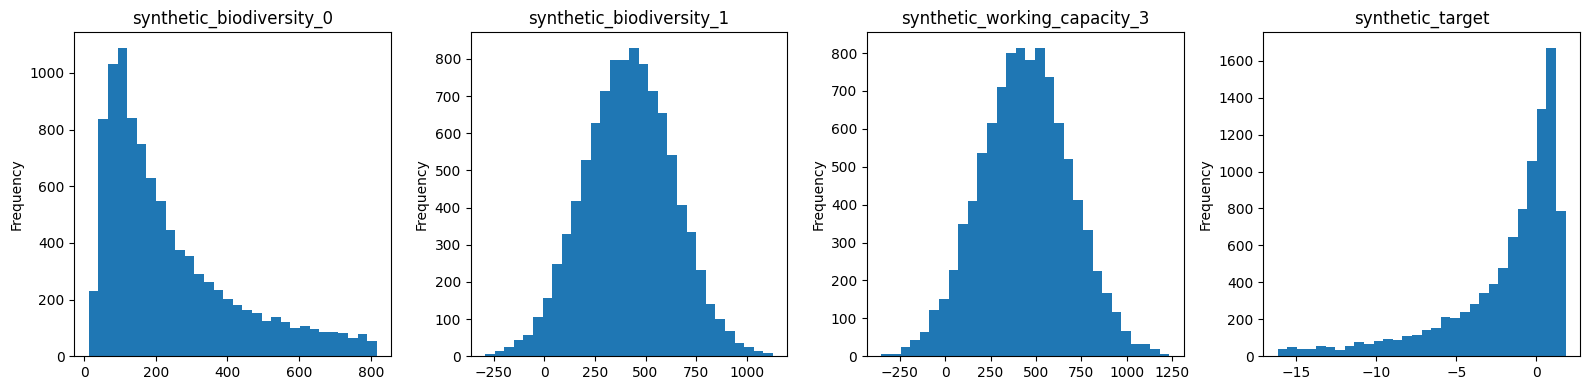

In [129]:
# Create a figure and a grid of subplots
fig, axs = plt.subplots(1, 4, figsize=(4 * 4, 4))

# Flatten the array of axes (subplots) for easy iteration
axs_flat = axs.flatten()

for i, column in enumerate(synthetic_env_data.columns):
    # Plot the column data in its own subplot
    synthetic_env_data[column].plot(kind='hist', bins=30, ax=axs_flat[i])
    axs_flat[i].set_title(column) 
plt.tight_layout()  # Adjust the layout to make sure there's no overlap
plt.show()

## Scaling the Numerical Data

In [130]:
standard_scaler = StandardScaler()
X_scaled=standard_scaler.fit_transform(synthetic_env_data.iloc[:, :-1])

In [131]:
y_scaled = standard_scaler.fit_transform(synthetic_env_data.iloc[:,-1].to_numpy().reshape(-1, 1))

In [132]:
print(X_scaled.shape)
print(y_scaled.shape)

(9757, 3)
(9757, 1)


## Data Transformation

In [133]:
# using sklearn to split the data before input into the tflow dataset class
X_train, X_test, y_train, y_test = train_test_split(X_scaled,
                                                    y_scaled,
                                                    test_size=0.2,
                                                    random_state=88)

In [134]:
# creating the test/train split
tf_train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(buffer_size=1024).batch(8)
tf_test_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(buffer_size=1024).batch(8)

# A Tensorflow Model Using the Built-in Einsum Method
The model in this section tests the tensorflow einsum method in the forward pass instead of matrix multiply. All other settings in the model architecture will remain in the same as in the matrix multiply model section.


## Creating the Model

In [135]:
class EinsumLayer(layers.Layer):
    def __init__(self, output_dim, **kwargs):
        super(EinsumLayer, self).__init__(**kwargs)
        self.output_dim = output_dim

    def build(self, input_shape):
        # Create a trainable weight variable for this layer,
        # which will serve as the second tensor in the einsum operation.
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(input_shape[-1], self.output_dim),
                                      initializer='uniform',
                                      trainable=True)

    def call(self, inputs):
        # Perform the einsum operation combining input tensor and the kernel
        # Here 'ij,jk->ik' essentially performs matrix multiplication
        return tf.einsum('ij,jk->ik', inputs, self.kernel)

In [136]:
# Instantiate a simple classification model
threeLayerNonLinearModel = tf.keras.Sequential([
  layers.Dense(3),
  EinsumLayer(output_dim=256),
  layers.Dense(256, activation=tf.nn.relu),
  layers.Dense(256, activation=tf.nn.relu),
  layers.Dense(1)
])

In [137]:
accuracy = tf.keras.metrics.MeanSquaredError()
optimizer = tf.keras.optimizers.SGD()

## Training the Model on the Synthetic Training Data

In [138]:
for step, (x, y) in enumerate(tf_train_dataset):
  # Open a GradientTape.
  with tf.GradientTape() as tape:

    # Forward pass.
    logits = threeLayerNonLinearModel(x)

    # Loss value for this batch.
    loss_value = tf.reduce_mean(tf.keras.losses.mse(y, logits))
     
  # Get gradients of loss wrt the weights.
  gradients = tape.gradient(loss_value, threeLayerNonLinearModel.trainable_weights)
  
  # Update the weights of our linear layer.
  optimizer.apply_gradients(zip(gradients, threeLayerNonLinearModel.trainable_weights))

  # Update the running accuracy.
  accuracy.update_state(y, logits)
  
  # Logging.
  if step % 10 == 0:
    print('Step:', step)
    print('Loss from last step: %.3f' % loss_value)
    print('Total running accuracy so far: %.3f' % accuracy.result())

2024-04-02 22:50:52.444341: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [7805,3]
	 [[{{node Placeholder/_0}}]]
2024-04-02 22:50:52.444824: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [7805,1]
	 [[{{node Placeholder/_1}}]]


Step: 0
Loss from last step: 0.528
Total running accuracy so far: 0.528
Step: 10
Loss from last step: 1.017
Total running accuracy so far: 1.042
Step: 20
Loss from last step: 0.839
Total running accuracy so far: 1.035
Step: 30
Loss from last step: 0.442
Total running accuracy so far: 0.924
Step: 40
Loss from last step: 0.406
Total running accuracy so far: 0.833
Step: 50
Loss from last step: 0.250
Total running accuracy so far: 0.805
Step: 60
Loss from last step: 0.944
Total running accuracy so far: 0.859
Step: 70
Loss from last step: 0.428
Total running accuracy so far: 0.915
Step: 80
Loss from last step: 1.096
Total running accuracy so far: 0.993
Step: 90
Loss from last step: 1.471
Total running accuracy so far: 1.013
Step: 100
Loss from last step: 1.242
Total running accuracy so far: 1.010
Step: 110
Loss from last step: 1.576
Total running accuracy so far: 1.010
Step: 120
Loss from last step: 0.425
Total running accuracy so far: 1.003
Step: 130
Loss from last step: 0.363
Total runnin

## Testing the Model

In [139]:
accuracy.reset_states()  # clearing the state of the accuracy post-training

for step, (x, y) in enumerate(tf_test_dataset):
  logits = threeLayerNonLinearModel(x)
  accuracy.update_state(y, logits)

print('test accuracy: %.3f' % accuracy.result())

2024-04-02 22:51:19.777313: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [7805,1]
	 [[{{node Placeholder/_1}}]]
2024-04-02 22:51:19.777778: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [7805,1]
	 [[{{node Placeholder/_1}}]]


test accuracy: 1.013


In [150]:
# predictions on the whole real dataset
predictions = threeLayerNonLinearModel(X.to_numpy())
# predictions on the synthetic testing set
test_predictions = threeLayerNonLinearModel(X_test)

# Evaluating the Model on the Simulated Testing Data

## The Real Data Y 'Truth' Labels

In [151]:
X = filtered_numerical_features.loc[:, ['biodiversity_0', 'biodiversity_1','working_capacity_3']].copy(deep=True)
y = filtered_numerical_features.loc[:, ['target']].copy(deep=True)

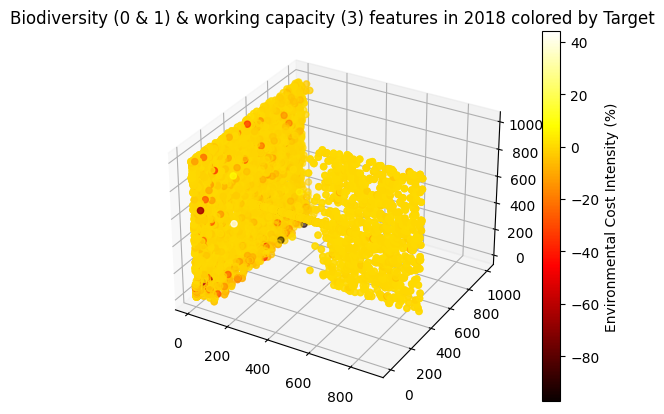

In [152]:
plot_4d(X['biodiversity_0'], X['biodiversity_1'], X['working_capacity_3'], y, title='Biodiversity (0 & 1) & working capacity (3) features in 2018 colored by Target')

## The Real Data Y 'Prediction' Labels

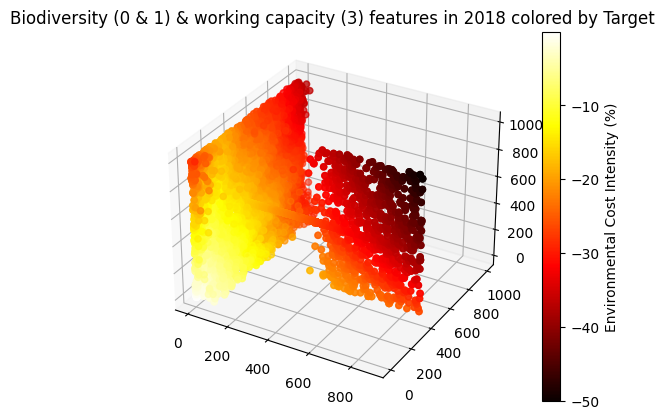

In [154]:
plot_4d(X['biodiversity_0'], X['biodiversity_1'], X['working_capacity_3'], predictions, title='Biodiversity (0 & 1) & working capacity (3) features in 2018 colored by Target')

## The Simulated Data Y 'Truth' Labels

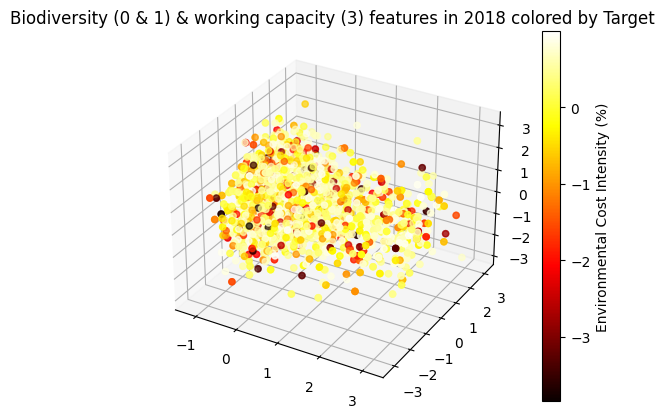

In [155]:
plot_4d(X_test[:,0], X_test[:,1], X_test[:,2], y_test, title='Biodiversity (0 & 1) & working capacity (3) features in 2018 colored by Target')

## The Simulated Data Y 'Prediction' Labels

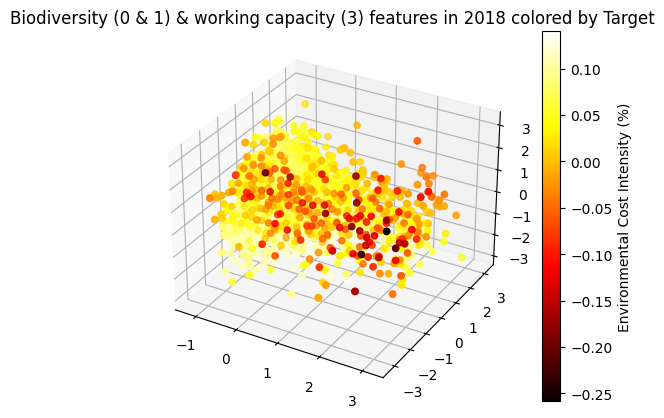

In [156]:
plot_4d(X_test[:,0], X_test[:,1], X_test[:,2], test_predictions[:,0], title='Biodiversity (0 & 1) & working capacity (3) features in 2018 colored by Target')